# Further Analysis for STAT3888 Group Project

### Importing Packages, Loading Data

In [61]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn import preprocessing
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


biom_data = pd.read_csv("data/tech_biom.csv")
nutr_data = pd.read_csv("data/AHS11nutrient.csv")

### Selecting Response Variables and Confounders

In [62]:
# Select relevant cardiovascular variables 
response_vars = ["ABSPID", "BMISC", "HCHOLBC", "CHOLRESB", "CHOLNTR", "HDLCHREB", "LDLNTR",
                "LDLRESB", "DIASTOL", "SYSTOL"]

biom_data.rename(columns={"ADTOTSE": "Minutes Sitting/Lying", "SMKSTAT":"Smoker status", "AGEC":"Age", \
                   "EXLWTBC": "Physical Activity", "SF2SA1QN": "Social Disadvantage Index", \
                   "SEX": 'Sex', "DIAHBRSK": "Risk of Diabetes"}, inplace = True)

confounders = ["Minutes Sitting/Lying", "Smoker status", "Age", "Physical Activity", \
               "Social Disadvantage Index", 'Sex', "Risk of Diabetes"]


cardio_data = biom_data[response_vars + confounders]


# Or as another option, selecting all the data variables
# cardio_data = biom_data[biom_data.columns[~biom_data.columns.str.endswith('MISS')]]

### Function to get the principal components of a selected group of features

In [63]:
def features_to_pcs(new_col_name, input_data, *features):
    pca = PCA(n_components = 1) # For now it uses the first PC, I guess we can change this to show all PCs and take only the important ones (i.e. left of elbow)
    
    selected_features_ptr = input_data.loc[:, [f for f in features]]
    
    # Convert to correct format (numpy.ndarray)
    selected_features_arr = selected_features_ptr.to_numpy()
    
    selected_features_arr = preprocessing.scale(selected_features_arr)
    
    pc = pca.fit_transform(selected_features_arr)
    pc_as_df = pd.DataFrame(data = pc)
    pc_as_df = pc_as_df.set_axis([*pc_as_df.columns[:-1], new_col_name], axis = 1, inplace = False)
    
    # Remove the original variables and replace them with the first PC
    input_data = input_data.drop(columns = [f for f in features])
    input_data = pd.concat([input_data, pc_as_df], axis = 1)
    
    return input_data

### Cleaning and Combining Data

In [64]:
# Drop all rows with missing values in cardiovascular data
cleaned_cardio_data = cardio_data.dropna()
cleaned_cardio_data

ABSPID      BMISC  HCHOLBC  CHOLRESB  CHOLNTR  HDLCHREB  \
1      NPA11B10000021  29.750000        5       7.0      2.0       2.0   
2      NPA11B10000031  24.379999        1       7.0      2.0       4.0   
3      NPA11B10000041  21.360001        5       4.0      1.0       5.0   
13     NPA11B10000101  19.690001        5       2.0      1.0       4.0   
15     NPA11B10000111  26.790001        3       6.0      2.0       3.0   
...               ...        ...      ...       ...      ...       ...   
12139  NPA11B10095091  23.410000        1       1.0      1.0       4.0   
12140  NPA11B10095101  23.680000        5       5.0      2.0       5.0   
12142  NPA11B10095111  28.090000        1       8.0      2.0       4.0   
12145  NPA11B10095141  21.730000        5       3.0      1.0       4.0   
12152  NPA11B10095191  25.340000        5       3.0      1.0       3.0   

       LDLNTR  LDLRESB  DIASTOL  SYSTOL  Minutes Sitting/Lying  Smoker status  \
1         2.0      7.0     76.0   124.0                 1750.0            4.0   
2         2.0      8.0     66.0   116.0                 1635.0            5.0   
3         1.0      4.0     77.0   112.0                 2080.0            5.0   
13        1.0      4.0     68.0    96.0                  900.0            4.0   
15        2.0      7.0     76.0   126.0                 2490.0            1.0   
...       ...      ...      ...     ...                    ...            ...   
12139     1.0      2.0     77.0   153.0                 1830.0            5.0   
12140     1.0      4.0     62.0   102.0                  390.0            4.0   
12142     2.0      8.0     76.0   125.0                 1560.0            5.0   
12145     1.0      4.0     69.0   103.0                 2350.0            5.0   
12152     1.0      4.0     71.0   131.0                 3990.0            4.0   

       Age  Physical Activity  Social Disadvantage Index  Sex  \
1       77                450                          3    1   
2       55                190                          2    2   
3       59                280                          5    2   
13      27                420                          4    2   
15      51                405                          5    1   
...    ...                ...                        ...  ...   
12139   84                180                          3    2   
12140   49                900                          1    2   
12142   55                  0                          5    2   
12145   54                580                          4    2   
12152   53                 20                          4    2   

       Risk of Diabetes  
1                   1.0  
2                   1.0  
3                   1.0  
13                  1.0  
15                  1.0  
...                 ...  
12139               1.0  
12140               1.0  
12142               1.0  
12145               1.0  
12152               1.0  

[2933 rows x 17 columns]

#### PCA of the Nutrient Dataset (Our predictor variables)

**Note**: In order to use PCs in our models we have to change all features to PCs
We must also standardize all variables first.

In [65]:
new_nutr_data = nutr_data.copy()
new_nutr_data.drop(columns = 'ABSHID', inplace = True)

print("BEFORE DATA:")
# print(new_nutr_data)

# new_nutr_data = features_to_pcs('RANDOM', new_nutr_data, 'BMR', 'ENRGYT2', 'ADDSUG2N', 'FRESUG2N') # To test functionality
new_nutr_data = features_to_pcs('Basal Metabolic Rate', new_nutr_data, 'BMR', 'EIBMR1', 'EIBMR2')
new_nutr_data = features_to_pcs('Energy', new_nutr_data, 'ENERGYT1', 'ENERGYT2', 'ENRGYT1', 'ENRGYT2')
new_nutr_data = features_to_pcs('Moisture', new_nutr_data, 'MOISTT1', 'MOISTT2')
new_nutr_data = features_to_pcs('Protein', new_nutr_data, 'PROTT1', 'PROTT2', 'PROPER1', 'PROPER2')
new_nutr_data = features_to_pcs('Fats', new_nutr_data, 'FATT1', 'FATT2', 'SATFATT1', 'SATFATT2', 'MUFATT1', 'MUFATT2', \
                                'PUFATT1', 'PUFATT2', 'TRANST1', 'TRANST2', 'FATPER1', 'FATPER2', 'SATPER1', 'SATPER2',\
                                'TRANPER1', 'TRANPER2', 'MONOPER1', 'MONOPER2', 'POLYPER1', 'POLYPER2') # We may need more PCs for this one
new_nutr_data = features_to_pcs('Carbohydrates', new_nutr_data, 'CHOWSAT1', 'CHOWSAT2', 'CHOWOAT1', 'CHOWOAT2', \
                                'CHOPER1', 'CHOPER2')
new_nutr_data = features_to_pcs('Starch', new_nutr_data, 'STARCHT1', 'STARCHT2', 'STARPER1', 'STARPER2')
new_nutr_data = features_to_pcs('Sugars', new_nutr_data, 'SUGART1', 'SUGART2', 'SUGPER1', 'SUGPER2', 'FRESUG1N', 'ADDSUG1N',\
                                'FRESUG2N', 'ADDSUG2N', 'PEFRESD1', 'PEFRESD2', 'PEADDSD1', 'PEADDSD2')
new_nutr_data = features_to_pcs('Fibre', new_nutr_data, 'FIBRET1', 'FIBRET2', 'FIBRPER1', 'FIBRPER2')
new_nutr_data = features_to_pcs('Alcohol', new_nutr_data, 'ALCT1', 'ALCT2', 'ALCPER1', 'ALCPER2')
new_nutr_data = features_to_pcs('Vitamin A', new_nutr_data, 'PREVAT1', 'PREVAT2', 'PROVAT1', 'PROVAT2')
new_nutr_data = features_to_pcs('Retinols', new_nutr_data, 'RETEQT1', 'RETEQT2')

#These are all vitamin B - we can combine possibly
new_nutr_data = features_to_pcs('Thiamin', new_nutr_data, 'B1T1', 'B1T2')
new_nutr_data = features_to_pcs('Riboflavin', new_nutr_data, 'B2T1', 'B2T2')
new_nutr_data = features_to_pcs('Niacin', new_nutr_data, 'B3T1', 'B3T2', 'NIACINT1', 'NIACINT2') 
new_nutr_data = features_to_pcs('B6', new_nutr_data, 'B6T1', 'B6T2') 
new_nutr_data = features_to_pcs('B12', new_nutr_data, 'B12T1', 'B12T2') 

new_nutr_data = features_to_pcs('Folates', new_nutr_data, 'FOLATT1', 'FOLATT2', 'FOLICT1', 'FOLICT2', 'TOTFOLT1', \
                                'TOTFOLT2', 'FOLEQT1', 'FOLEQT2') 
new_nutr_data = features_to_pcs('Vitamin C', new_nutr_data, 'VITCT1', 'VITCT2') 
new_nutr_data = features_to_pcs('Vitamin E', new_nutr_data, 'VITET1', 'VITET2') 
new_nutr_data = features_to_pcs('Calcium', new_nutr_data, 'CALCT1', 'CALCT2') 
new_nutr_data = features_to_pcs('Iodine', new_nutr_data, 'IODINET1', 'IODINET2') 
new_nutr_data = features_to_pcs('Iron', new_nutr_data, 'IRONT1', 'IRONT2')
new_nutr_data = features_to_pcs('Magnesium', new_nutr_data, 'MAGT1', 'MAGT2')
new_nutr_data = features_to_pcs('Phosphorous', new_nutr_data, 'PHOST1', 'PHOST2')
new_nutr_data = features_to_pcs('Potassium', new_nutr_data, 'POTAST1', 'POTAST2')
new_nutr_data = features_to_pcs('Selenium', new_nutr_data, 'SELT1', 'SELT2')
new_nutr_data = features_to_pcs('Sodium', new_nutr_data, 'SODIUMT1', 'SODIUMT2')
new_nutr_data = features_to_pcs('Zinc', new_nutr_data, 'ZINCT1', 'ZINCT2')
new_nutr_data = features_to_pcs('Caffeine', new_nutr_data, 'CAFFT1', 'CAFFT2')
new_nutr_data = features_to_pcs('Cholesterol', new_nutr_data, 'CHOLT1', 'CHOLT2')
new_nutr_data = features_to_pcs('Linoleic Acid', new_nutr_data, 'LAT1', 'LAT2', 'ALAT1', 'ALAT2', 'LAPER1', \
                                'LAPER2', 'ALAPER1', 'ALAPER2')
new_nutr_data = features_to_pcs('Omega 3', new_nutr_data, 'LCN3T1', 'LCN3T2')
new_nutr_data = features_to_pcs('Grains and Cereals', new_nutr_data, 'GRAINS1N', 'WHOLGR1N', 'REFGRA1N', 'GRAINS2N')
new_nutr_data = features_to_pcs('Vegetables & Legumes', new_nutr_data, 'VEGLEG1N', 'GREENS1N', 'VGORSV1N', 'STARCH1N', \
                                'STARCH1N', 'LEGVEG1N', 'OTHVEG1N', 'LEGMT1N', 'VEGLEG2N')
new_nutr_data = features_to_pcs('Fruit', new_nutr_data, 'FRUIT1N', 'FRSHF1N', 'DRFR1N', 'FRJUIC1N', 'FRUIT2N', 'FRSHF2N')
new_nutr_data = features_to_pcs('Dairy', new_nutr_data, 'DAIRY1N', 'DAIRHF1N', 'DAIRHF1N', 'DAIRMF1N', 'DAIRLF1N', 'DAIRY2N')
new_nutr_data = features_to_pcs('Meats & Poultry', new_nutr_data, 'MEAT1N', 'MEATL1N', 'MEATLD1N', 'RDMTL1N', 'RDMTLU1N', \
                                'RDMTLP1N', 'RDMTN1N', 'RDMTNU1N', 'RDMTNP1N', 'PLTYL1N', 'PLTYLU1N', 'FISH1N', \
                                'MEATLG1N', 'MEATDG1N', 'RDMTLG1N', 'RDMLUG1N', 'RDMLPG1N', 'RDMTNG1N', \
                                'RDMNUG1N', 'RDMNPG1N', 'PLTYLG1N', 'PLTLUG1N', 'PLTLPG1N', 'PLTYNG1N', \
                                'PLTNUG1N', 'PLTNPG1N', 'RDMTTG1N', 'RDMTUG1N', 'PLTYTG1N', 'PLTYUG1N', 'MEAT2N', \
                                'MEATLD2N', 'MEATL2N')
new_nutr_data = features_to_pcs('Eggs', new_nutr_data, 'EGGS1N')
new_nutr_data = features_to_pcs('Nuts & Seeds', new_nutr_data, 'NUTS1N')
new_nutr_data = features_to_pcs('Water', new_nutr_data, 'WATER1N', 'WATERG1N', 'WATERG2N', 'WATER2N')
new_nutr_data = features_to_pcs('Spreads & Oils', new_nutr_data, 'UNSAT1N', 'UNSAT2N')

print()
print("AFTER DATA:")
print(new_nutr_data)

BEFORE DATA:

AFTER DATA:
               ABSPID  Basal Metabolic Rate    Energy  Moisture   Protein  \
0      NPA11B10000011             -0.957076  4.029340  0.462707  2.699636   
1      NPA11B10000021             -0.932059  0.338946  0.625305  1.762102   
2      NPA11B10000031             -0.959216  0.445303  1.503037  0.590192   
3      NPA11B10000041             -0.961966  1.363277  1.548484  1.419203   
4      NPA11B10000051              3.429765  2.547113  0.081372 -0.014883   
...               ...                   ...       ...       ...       ...   
12148  NPA11B10095161              3.428845 -1.296236 -0.302641 -1.166903   
12149  NPA11B10095171             -0.036349 -1.064087 -0.987763 -1.531023   
12150  NPA11B10095181             -0.043699 -0.991718 -1.409639 -0.760329   
12151  NPA11B10095182             -0.017106  1.747148 -0.886556 -0.904296   
12152  NPA11B10095191             -0.956075  1.260068 -0.934408 -0.781790   

           Fats  Carbohydrates    Starch    Sugar

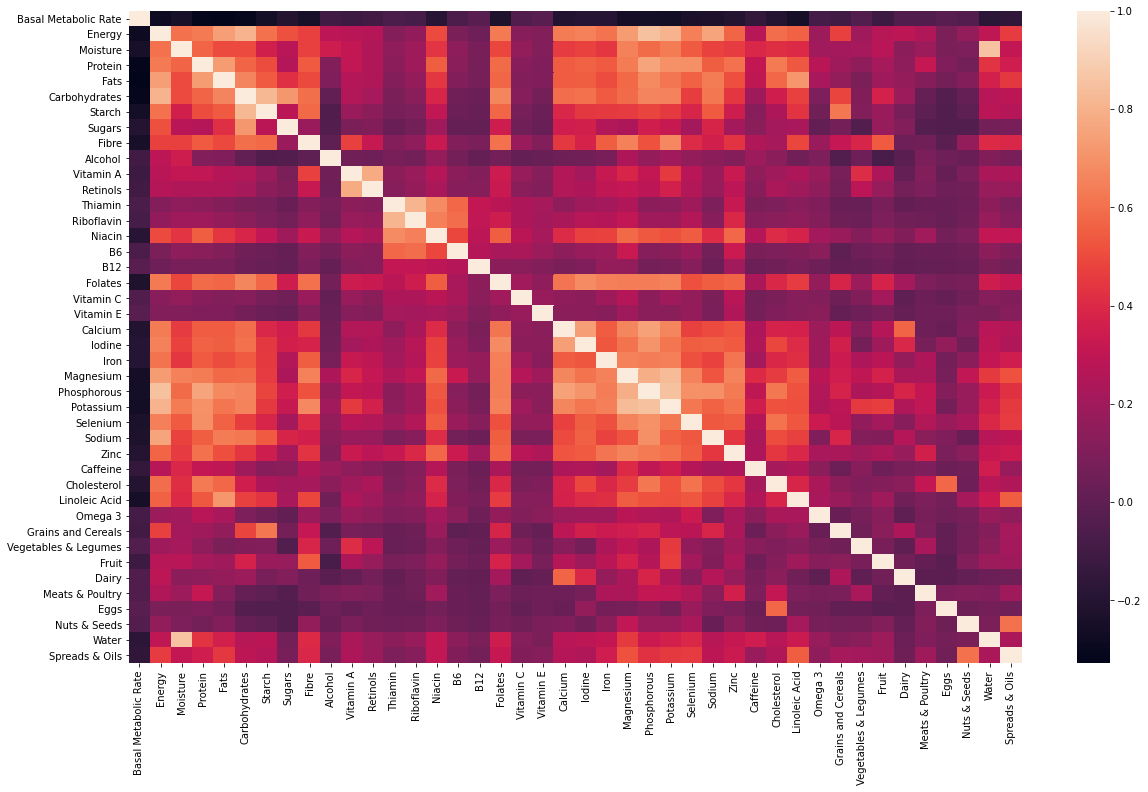

In [66]:
# Explore Correlation Matrix for Nutrition data - important to look to multicollinearity
plt.rcParams['figure.figsize'] = (20, 12)
sn.heatmap(new_nutr_data.corr())
plt.show()

#### Further cleaning and combining the data

In [67]:
# # Drop all rows with missing values in cardiovascular data and combine to make final dataset
# cleaned_cardio_data = cardio_data.dropna()
combined_data = pd.merge(cardio_data, new_nutr_data, on = "ABSPID").dropna()
combined_data.to_csv("PC_combined_data.csv")

### Setting up Prediction Variables (X)

In [68]:
X = combined_data.drop(response_vars, axis = 1)
# X.apply(stats.zscore)
# X_columns = X.columns
# X = preprocessing.scale(X)

In [69]:
combined_data['SYSTOL']

1        124.0
2        116.0
3        112.0
13        96.0
15       126.0
         ...  
12139    153.0
12140    102.0
12142    125.0
12145    103.0
12152    131.0
Name: SYSTOL, Length: 2933, dtype: float64

### Function for Lasso Regression

In [70]:
def lasso_reg(response):
    y = combined_data[response]
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    reg = LassoCV(cv = cv, max_iter = 100000)
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV (R-Squared): %f" % reg.score(X,y))
    
    coef = pd.Series(reg.coef_, index = X.columns)
    
    # Subset to only non-zero coefficients and plot.
    coef = coef[coef != 0]
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Regression for " + response)
    plt.ylabel('Predictor Variable')
    plt.xlabel('Coefficient Estimate')

### OLS Regression

In [71]:
def OLS(response, predictors):
    y = combined_data[response]
    x = X[predictors]
    results = sm.OLS(y, x).fit()
    print(results.summary())

### Function for Ridge Regression

In [72]:
def ridge_reg(response):
    y = combined_data[response]
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    reg = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
    # fit model
    reg.fit(X, y)
    # summarize chosen configuration
    print('alpha: %f' % reg.alpha_)
    reg.fit(X, y)
    
    print("Best score using built-in RidgeCV (R-Squared): %f" % reg.score(X,y))
    coef = pd.Series(reg.coef_, index = X_columns)
    
    # Subset to only non-zero coefficients and plot.
    coef = coef[coef != 0]
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 12.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Ridge Regression for " + response)
    plt.ylabel('Predictor Variable')
    plt.xlabel('Coefficient Estimate')

### Multinomial Logistic Regression

In [73]:
def multi_logit_reg(response):
    y = combined_data[response]
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    # define the model evaluation procedure
    cv = StratifiedKFold(n_splits=10, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report the model performance
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

### Function for Random Forest

In [74]:
def random_forest(response):
    
    y = combined_data[response]
    
    # KFOLD CV TO GET MODEL ACCURACY
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    # create model
    model = RandomForestClassifier()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


    #SIMPLE TRAIN TEST SPLIT FOR FEATURE IMPORTANCE
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)
    result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending = False)
    
    
#     model.fit(X, y)
#     plt.barh(X.columns, model.feature_importances_)
#     plt.xlabel("Mean Permutation Accuracy Decrease")
    
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax = plt.subplots()
    forest_importances[1:10].plot.bar(ax=ax)   # SHOW ONLY FIRST 10
    ax.set_title("Feature importances using Random Forest Model for " + response)
    ax.set_ylabel("Mean Permutation Accuracy Decrease")
    fig.tight_layout()
    plt.show()

#     importances = model.feature_importances_
#     forest_importances = pd.Series(importances, index=feature_names)

#     fig, ax = plt.subplots()
#     forest_importances.plot.bar(yerr=std, ax=ax)
#     ax.set_title("Feature importances using MDI")
#     ax.set_ylabel("Mean decrease in impurity")
#     fig.tight_layout()
    
    # Explanation for permutation importance
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

Accuracy: 0.199 (0.024)


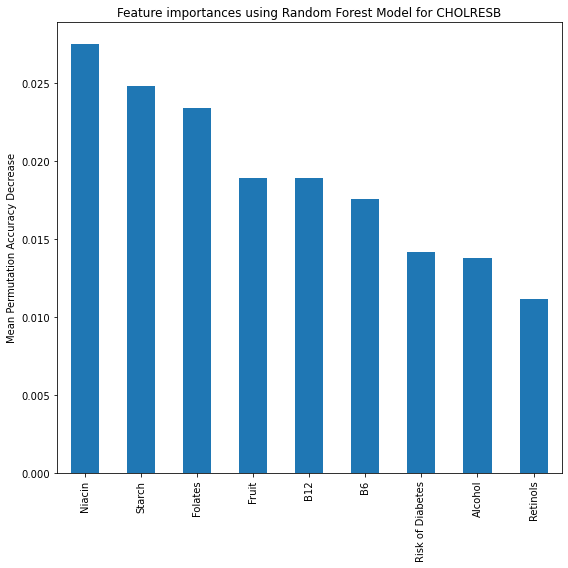

In [75]:
random_forest("CHOLRESB")

In [16]:
def decision_tree(response):
    y = combined_data[response]
    model = DecisionTreeClassifier()
    # fit the model
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

### SYSTOL

Best alpha using built-in LassoCV: 0.465464
Best score using built-in LassoCV (R-Squared): 0.240441


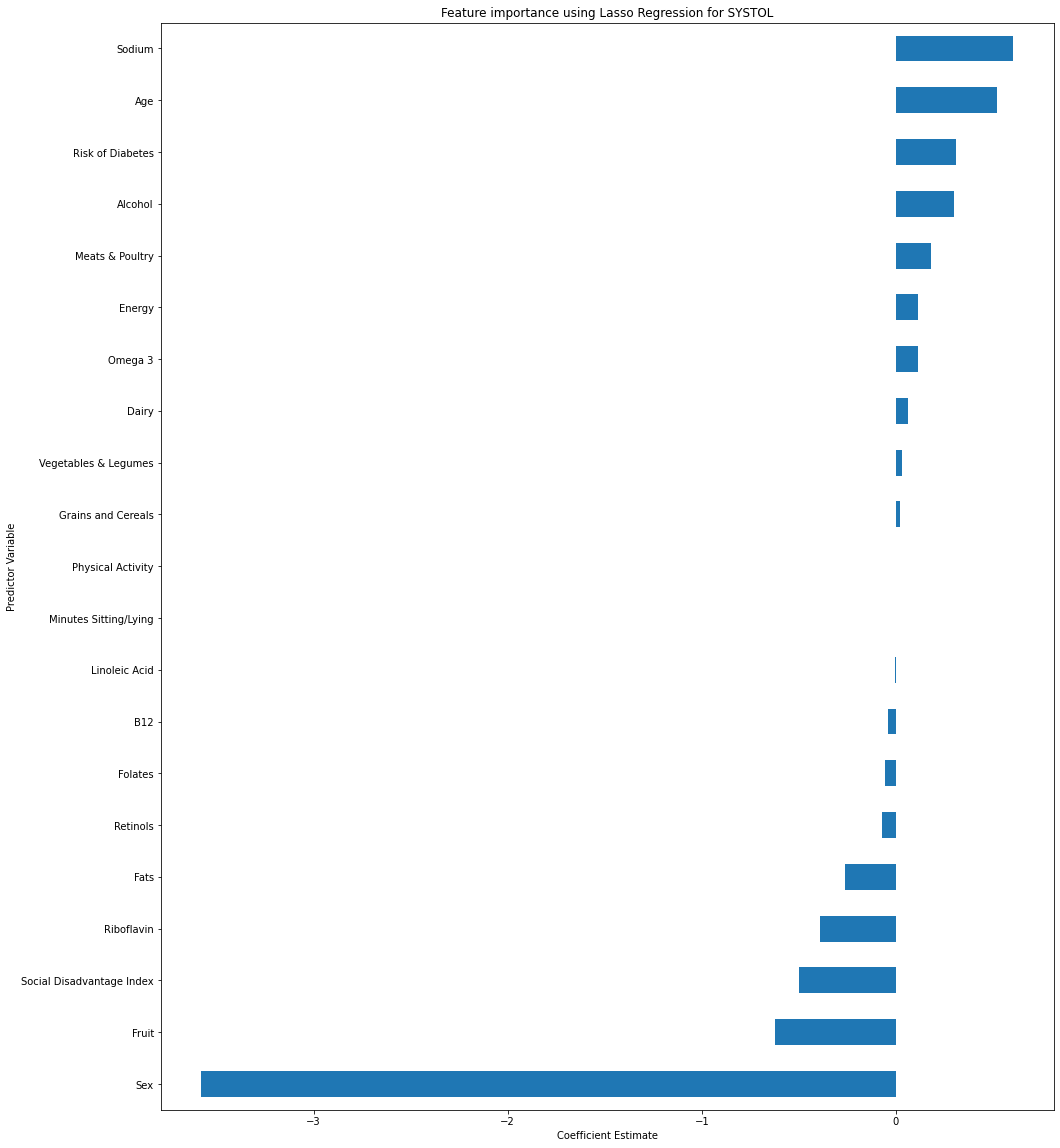

In [27]:
lasso_reg("SYSTOL")

In [111]:
systol_predictors = ['Sex']
# , 'Risk of Diabetes', 'Alcohol', 'Sodium', 'Basal Metabolic Rate', 'Phosphorous',\
#                      'B6', 'Meats & Poultry', 'Sex', 'Fruit', 'Social Disadvantage Index', 'Magnesium', \
#                      'Riboflavin', 'Fats', 'Zinc', 'Retinols', 'Folates'

In [112]:
combined_data('SYSTOL', systol_predictors)

TypeError: 'DataFrame' object is not callable

alpha: 0.990000
Best score using built-in RidgeCV (R-Squared): 0.254771


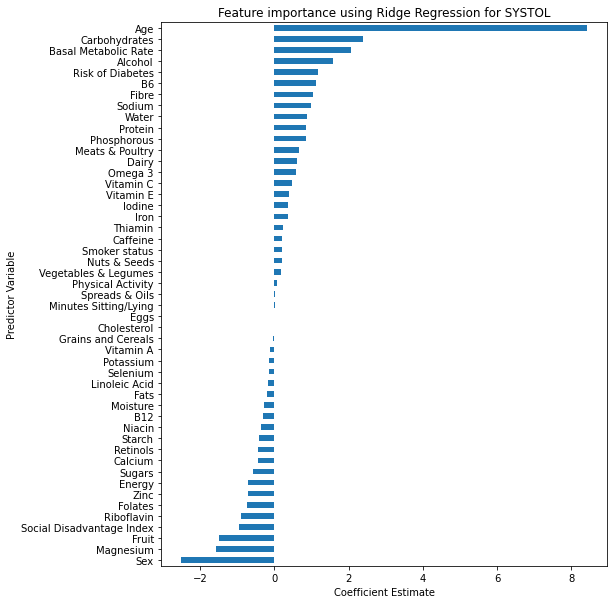

In [16]:
ridge_reg("SYSTOL")

### DIASTOL

Best alpha using built-in LassoCV: 5.544085
Best score using built-in LassoCV (R-Squared): 0.085189


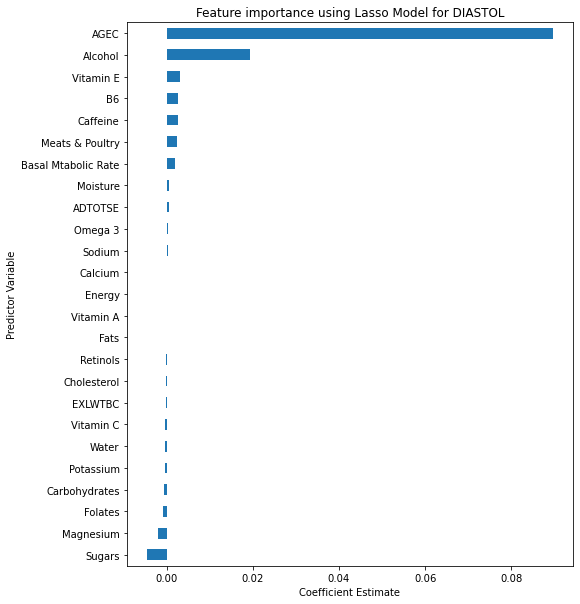

In [24]:
lasso_reg("DIASTOL")

### BMISC

Best alpha using built-in LassoCV: 0.590303
Best score using built-in LassoCV (R-Squared): 0.050550


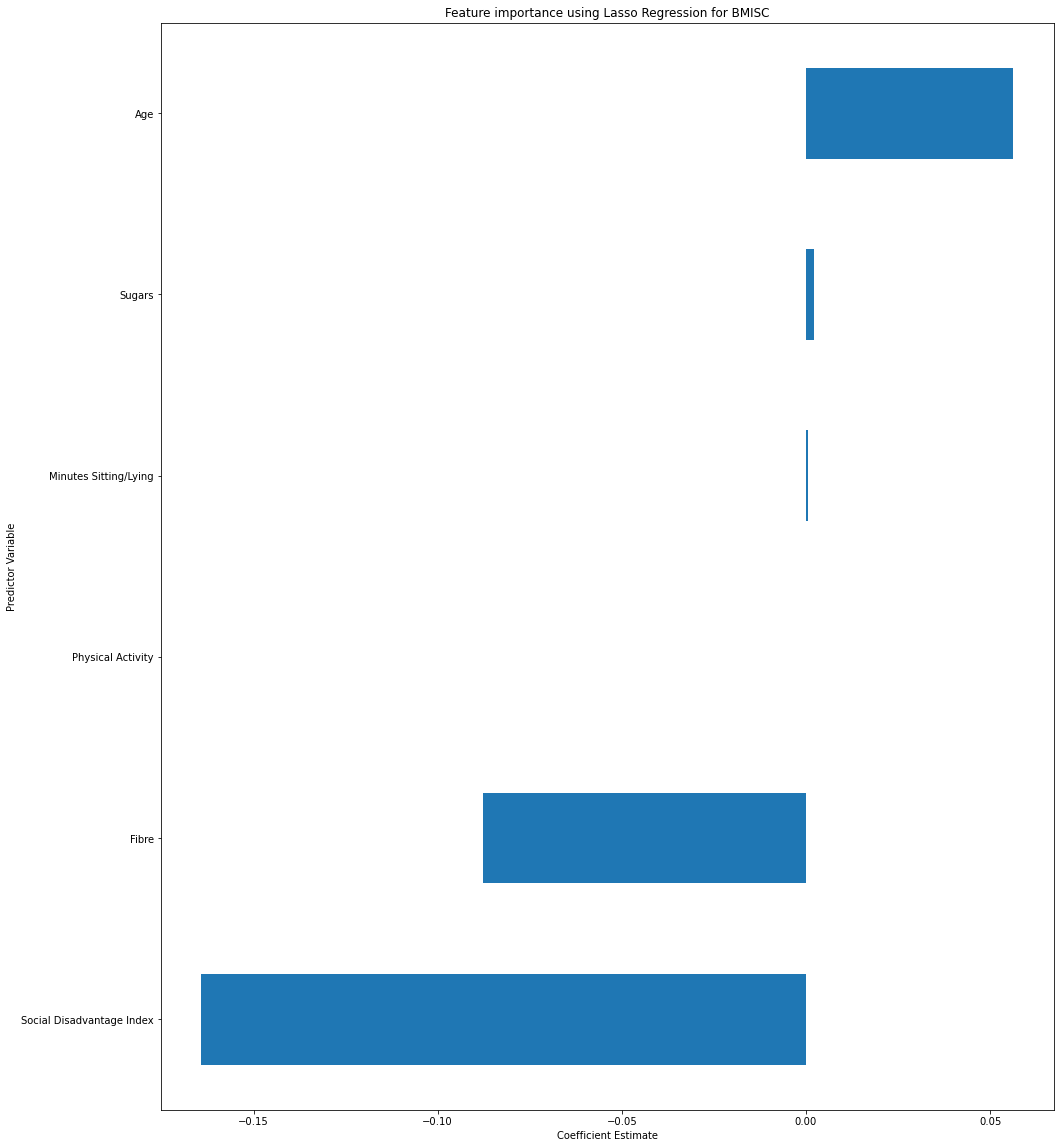

In [28]:
lasso_reg("BMISC")

### CHOLRESB

Accuracy: 0.220 (0.017)


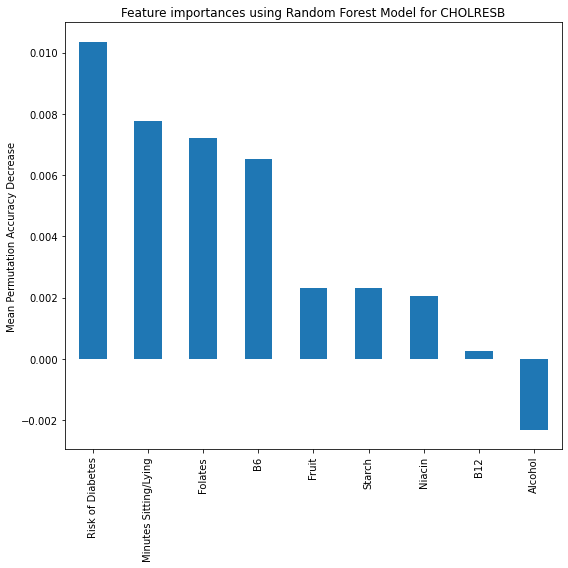

In [30]:
random_forest("CHOLRESB")

Best alpha using built-in LassoCV: 0.062633
Best score using built-in LassoCV (R-Squared): 0.055374


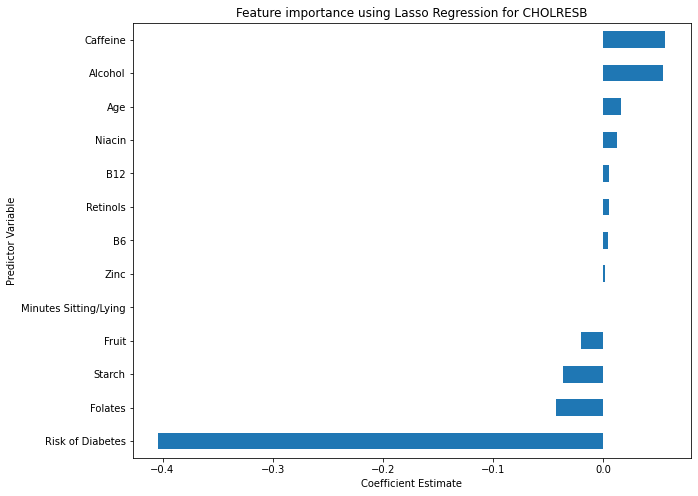

In [40]:
lasso_reg("CHOLRESB")

### CHOLNTR

Accuracy: 0.629 (0.019)


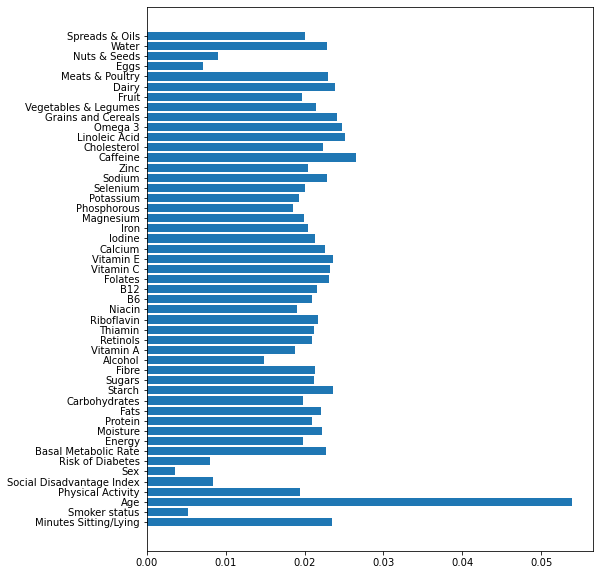

In [118]:
random_forest("CHOLNTR")

### HDLCHREB

Best alpha using built-in LassoCV: 0.568918
Best score using built-in LassoCV (R-Squared): 0.248107


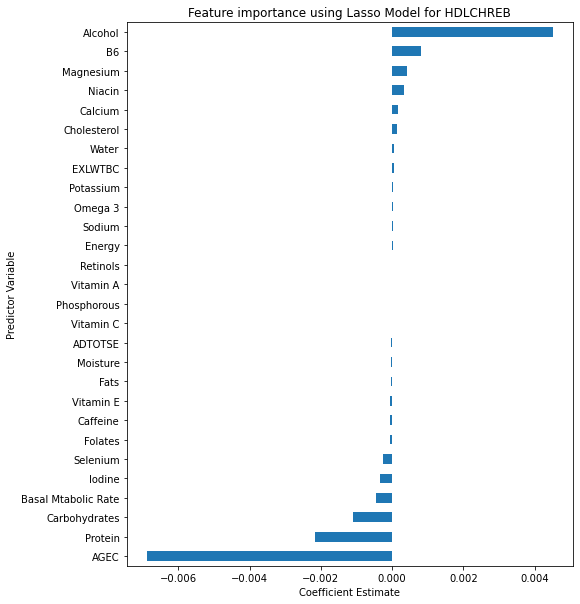

In [28]:
lasso_reg("HDLCHREB")

Accuracy: 0.397 (0.033)


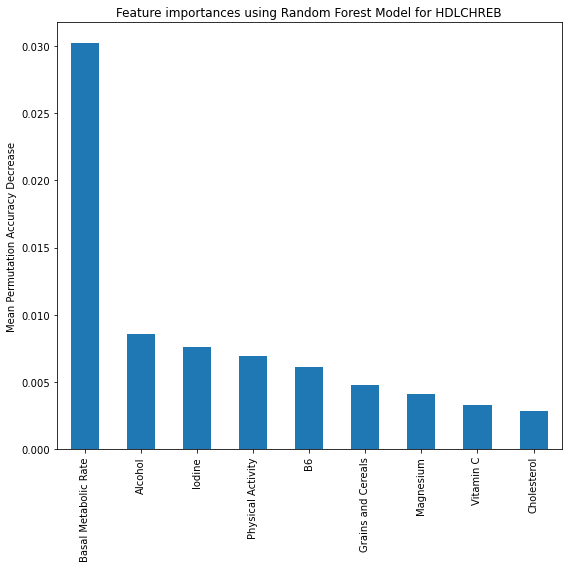

In [127]:
random_forest("HDLCHREB")

### LDLNTR

Accuracy: 0.642 (0.028)


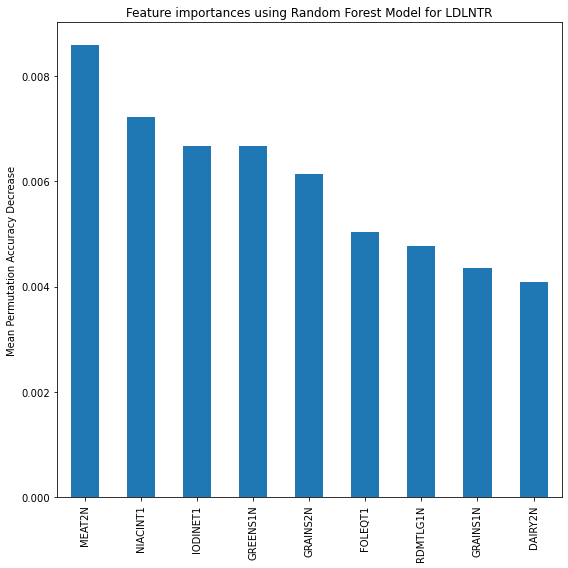

In [13]:
random_forest("LDLNTR")

### LDLRESB

Best alpha using built-in LassoCV: 0.100128
Best score using built-in LassoCV (R-Squared): 0.054176


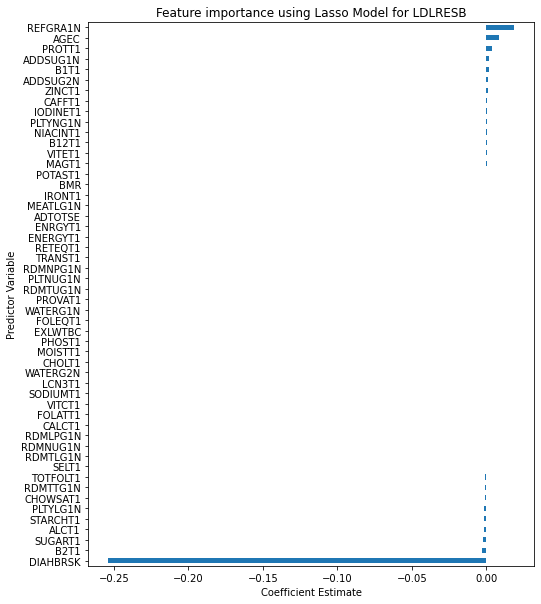

In [14]:
lasso_reg("LDLRESB")

Accuracy: 0.222 (0.018)


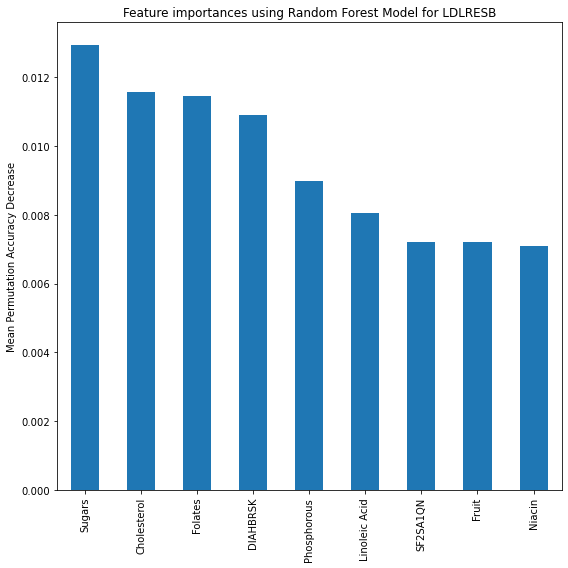

In [30]:
random_forest("LDLRESB")

### HSUGBC

Accuracy: 0.955 (0.015)


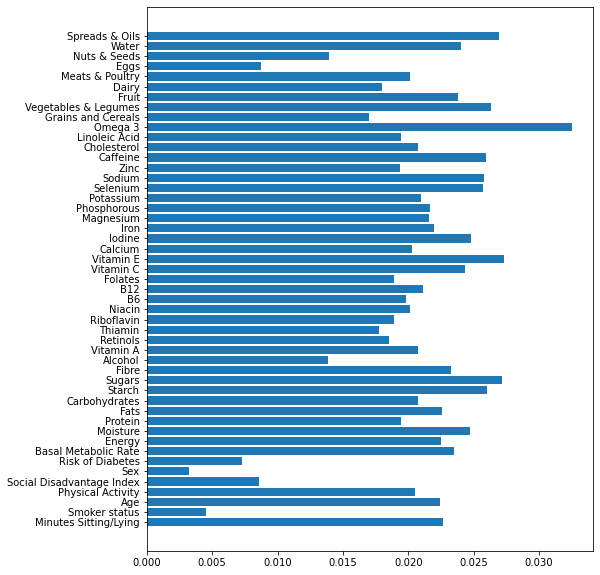

In [41]:
random_forest("HSUGBC")